In [1]:
import json
import time
from tqdm import tqdm
from pprint import pprint
from typing import List, Dict

import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import youtokentome as yttm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence

## Data

In [2]:
qa_data = list()

with open('qa_data.jsonl') as file_object:
    for line in file_object:
        qa_data.append(json.loads(line.strip().lower()))

In [3]:
pprint(qa_data[0])

{'category': 'бизнес, финансы',
 'question': 'долго ли идут деньги с яндексденег на карту visa?',
 'responses': ['нет. прорыв 35 ;)']}


## YTTM

In [4]:
# with open('for_bpe.txt', 'w', encoding='utf-8') as f:
#     for sample in qa_data:
#         f.write(sample['question'] + '\n')
#         for response in sample['responses']:
#             f.write(response + '\n')

In [5]:
model_path = 'pretrained_bpe_lm.model'

In [6]:
# %%time

# vocab_size = 30_000
# yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

In [7]:
tokenizer = yttm.BPE(model=model_path)

## Conditioning

Let's associate every category with a vector and append it to our attention vectors before prediction. We will use _nn.Embedding()_ for that, so feeding the model indices is the way to go.

In [8]:
categories = {sample['category'] for sample in qa_data}
category_mapping = {
    category: i for i, category in enumerate(categories)
}

category_mapping

{'спорт': 0,
 'работа, карьера': 1,
 'философия, непознанное': 2,
 'искусство и культура': 3,
 'знакомства, любовь, отношения': 4,
 'еда, кулинария': 5,
 'семья, дом, дети': 6,
 'животные, растения': 7,
 'образование': 8,
 'бизнес, финансы': 9,
 'авто, мото': 10,
 'путешествия, туризм': 11,
 'стиль, мода, звезды': 12,
 'досуг, развлечения': 13,
 'красота и здоровье': 14}

## Dataset

In [9]:
tokenizer.vocab()[:10]

['<PAD>', '<UNK>', '<BOS>', '<EOS>', '▁', 'о', 'е', 'а', 'т', 'и']

In [10]:
tokenizer.encode('что вообще происходит?', bos=True, eos=True, output_type=yttm.OutputType.SUBWORD)

['<BOS>', '▁что', '▁вообще', '▁происходит?', '<EOS>']

In [11]:
tokenizer.encode('что вообще происходит?', bos=True, eos=True)

[2, 756, 1120, 21259, 3]

In [12]:
class Seq2SeqBucketingDataset(Dataset):
    
    def __init__(self,
                 data: List[Dict],
                 tokenizer,
                 bos_index: int = 2,
                 eos_index: int = 3,
                 pad_index: int = 0,
                 max_len: int = 50,
                 batch_size: int = 256,
                 is_sorted: bool = False):
        
        self.tokenizer = tokenizer
        self.cache = {}
        self.data = self.prepare_batches(data, batch_size)
        self.max_len = max_len
        self.pad_index = pad_index
        self.bos_index = bos_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def encode(self, sentence: str) -> List[int]:
        if sentence in self.cache:
            return self.cache[sentence]
        indices = tokenizer.encode(sentence, bos=False, eos=False)
        self.cache[sentence] = indices

        return indices
    
    def prepare_batches(self, data, batch_size):
        tokenized = []
        for sample in tqdm(data):
            q = self.encode(sample['question'])
            category = category_mapping[sample['category']]
            for r in set(sample['responses']):
                tokenized.append((q, self.encode(r), category))

        data = sorted(tokenized, key=lambda x: -len(x[0]))
        
        batched_data = []
        for i_batch in range(math.ceil(len(data) / batch_size)):
            batched_data.append((
                [x[0] for x in data[i_batch * batch_size: (i_batch+1) * batch_size]],
                [x[1] for x in data[i_batch * batch_size: (i_batch+1) * batch_size]],
                [x[2] for x in data[i_batch * batch_size: (i_batch+1) * batch_size]]
            ))

        return batched_data
    
    def prepare_sequence(self, sequence, max_length):
        sequence = [self.bos_index] + sequence[:max_length - 2] + [self.eos_index]
        sequence += [self.pad_index] * (max_length - len(sequence))
        
        return sequence
        
    def __getitem__(self, index):
        batch = self.data[index]
        
        max_len_x = min([self.max_len, max([len(sample) for sample in batch[0]])])
        max_len_y = min([self.max_len, max([len(sample) for sample in batch[1]])])
        
        batch_x = [self.prepare_sequence(x, max_len_x) for x in batch[0]]
        batch_y = [self.prepare_sequence(y, max_len_y) for y in batch[1]]
        batch_categories = torch.tensor(batch[2]).long()
        
        batch_x = pack_sequence(torch.tensor(batch_x).long())
        batch_y = torch.tensor(batch_y).long()
        
        return batch_x, batch_y, batch_categories

In [13]:
train, val = train_test_split(qa_data, test_size=0.1, stratify=[sample['category'] for sample in qa_data], random_state=42)

In [14]:
train_dataset = Seq2SeqBucketingDataset(train, tokenizer)
val_dataset = Seq2SeqBucketingDataset(val, tokenizer)

collate_fn = lambda x: x[0]
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

100%|██████████| 280882/280882 [00:15<00:00, 18202.49it/s]


## Model

In [15]:
class SpatialDropout(nn.Dropout2d):
    def __init__(self, p):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.unsqueeze(2)  # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [16]:
class Seq2SeqModel(nn.Module):
    def __init__(self,
                 vocab_size: int = 30000,
                 embedding_dim: int = 100,
                 model_dim: int = 128,
                 cat_vocab_size: int = 15,
                 cat_embedding_dim: int = 5,
                 num_layers: int = 1,
                 embedding_dropout: float = 0.25,
                 dropout: float = 0.5,
                 padding_idx: int = 0):
        
        super().__init__()
        
        self.num_layers = num_layers
        self.padding_idx = padding_idx
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=padding_idx)
        self.embedding_dropout = SpatialDropout(p=embedding_dropout)
        
        self.encoder = nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, num_layers=num_layers,
                               bidirectional=True, dropout=dropout, batch_first=True)
        
        self.cat_embedding = nn.Embedding(num_embeddings=cat_vocab_size, embedding_dim=cat_embedding_dim)
        self.decoder = nn.LSTM(input_size=embedding_dim, hidden_size=model_dim * 2, num_layers=num_layers,
                               bidirectional=False, dropout=dropout, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.lm_head = nn.Linear(in_features=model_dim * 4 + cat_embedding_dim, out_features=vocab_size)
    
    @staticmethod
    def mask_attn_weights(attn_weights, masking_lengths):
        max_length = attn_weights.size(2)
        mask = torch.arange(max_length)[None, None, :] < masking_lengths[:, None, None]
        mask = mask.expand(-1, attn_weights.size(1), -1)
        attn_weights[~mask] = float('-inf')

        return attn_weights
        
    def calculate_attention(self, x, y, x_lengths):
        attn_weights = torch.bmm(y, x.transpose(1, 2))
        attn_weights = self.mask_attn_weights(attn_weights, x_lengths)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attention = torch.bmm(attn_weights, x)
        
        return attention
        
    @staticmethod
    def reshape_hidden_states(hidden_states):
        fwd_hidden = hidden_states[0:hidden_states.size(0):2]
        bwd_hidden = hidden_states[1:hidden_states.size(0):2]
        hidden_states = torch.cat([fwd_hidden, bwd_hidden], dim=2)
        
        return hidden_states
        
    def forward(self, x, y, categories):
        x, x_lengths = pad_packed_sequence(x, batch_first=True, padding_value=self.padding_idx)
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        
        x = pack_padded_sequence(x, x_lengths, batch_first=True)
        x, (eh, ec) = self.encoder(x)
        x, x_lengths = pad_packed_sequence(x, batch_first=True, padding_value=self.padding_idx)
        
        y = self.embedding(y)
        y = self.embedding_dropout(y)
        
        eh = self.reshape_hidden_states(eh)
        ec = self.reshape_hidden_states(ec)
        y, _ = self.decoder(y, (eh, ec))
        
        attention = self.calculate_attention(x, y, x_lengths)
        categories = self.cat_embedding(categories).unsqueeze(1).expand(-1, y.size(1), -1)
        combined = self.dropout(torch.cat([y, attention, categories], dim=-1))
        logits = self.lm_head(combined)
        
        return logits

In [17]:
model = Seq2SeqModel()

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Training

In [18]:
class Trainer:
    def __init__(self,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 model_path='model.pt',
                 grad_acc_steps=4,
                 device='cpu'):
        
        model.to(device)
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.grad_acc_steps = grad_acc_steps
        self.device = device

        if not model_path.endswith('.pt'):
            model_path += '.pt'
        self.model_path = model_path

        self.train_losses = []
        self.train_epoch_losses = []
        self.valid_epoch_losses = []

    def train(self,
              train_loader,
              valid_loader,
              last_n_losses=500,
              num_epochs=100,
              clip=3.,
              verbose=True):
        best_valid_loss = float('inf')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}:')
            time.sleep(0.5)

            self.model.train()

            train_epoch_losses = []

            progress_bar = tqdm(total=len(train_loader), disable=not verbose,
                                position=0, leave=True, desc='Current progress: ')

            for i, (x, y, categories) in enumerate(train_loader):
                y_in = y[:, :-1]
                y_out = y[:, 1:]
                
                x = x.to(self.device)
                y_in = y_in.to(self.device)
                y_out = y_out.to(self.device)
                categories = categories.to(self.device)
                
                logits = self.model(x, y_in, categories)

                loss = self.criterion(logits.transpose(1, 2), y_out)
                self.train_losses.append(loss.item())
                train_epoch_losses.append(loss.item())
                
                mean_loss = np.mean(self.train_losses[-last_n_losses:])
                progress_bar.set_description(
                    f'Loss: {mean_loss} Perplexity: {np.exp(mean_loss)}')
                progress_bar.update()
                
                loss = loss / self.grad_acc_steps
                loss.backward()
                
                if (i+1) % self.grad_acc_steps == 0:
                    nn.utils.clip_grad_norm_(self.model.parameters(), clip)
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            progress_bar.close()

            train_epoch_loss = np.mean(train_epoch_losses)
            self.train_epoch_losses.append(train_epoch_loss)

            valid_epoch_loss = self.evaluate(valid_loader)
            self.valid_epoch_losses.append(valid_epoch_loss)
            
            self.scheduler.step(valid_epoch_loss)

            print(f'Mean training loss: {train_epoch_loss}. Mean validation loss: {valid_epoch_loss}.\n')

            if valid_epoch_loss / best_valid_loss > 1.1:
                print('Validation performance has started degrading. Performing early stopping.')
                break

            if valid_epoch_loss < best_valid_loss:
                best_valid_loss = valid_epoch_loss
                torch.save(self.model.state_dict(), self.model_path.replace('.pt', '_best.pt'))

        return self.model

    def evaluate(self, valid_loader):
        self.model.eval()

        losses = []
        
        for x, y, categories in valid_loader:
            with torch.no_grad():
                y_in = y[:, :-1]
                y_out = y[:, 1:]

                x = x.to(self.device)
                y_in = y_in.to(self.device)
                y_out = y_out.to(self.device)
                categories = categories.to(self.device)

                logits = self.model(x, y_in, categories)

                losses.append(self.criterion(logits.transpose(1, 2), y_out).item())

        return np.mean(losses).item()

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, threshold=0.1, min_lr=1e-5)

trainer = Trainer(model, criterion, optimizer, scheduler, device='cuda:0')

In [20]:
trainer.train(train_loader, val_loader, num_epochs=2)

Epoch 1/2:


Loss: 6.284877604484558 Perplexity: 536.3986338322612: 100%|██████████| 27285/27285 [1:20:14<00:00,  5.67it/s]   


Mean training loss: 6.705601697984318. Mean validation loss: 5.978469711002054.

Epoch 2/2:


Loss: 6.047863467216492 Perplexity: 423.20786595286125: 100%|██████████| 27285/27285 [1:20:24<00:00,  5.66it/s] 


Mean training loss: 6.1410089397028464. Mean validation loss: 5.713077190876793.


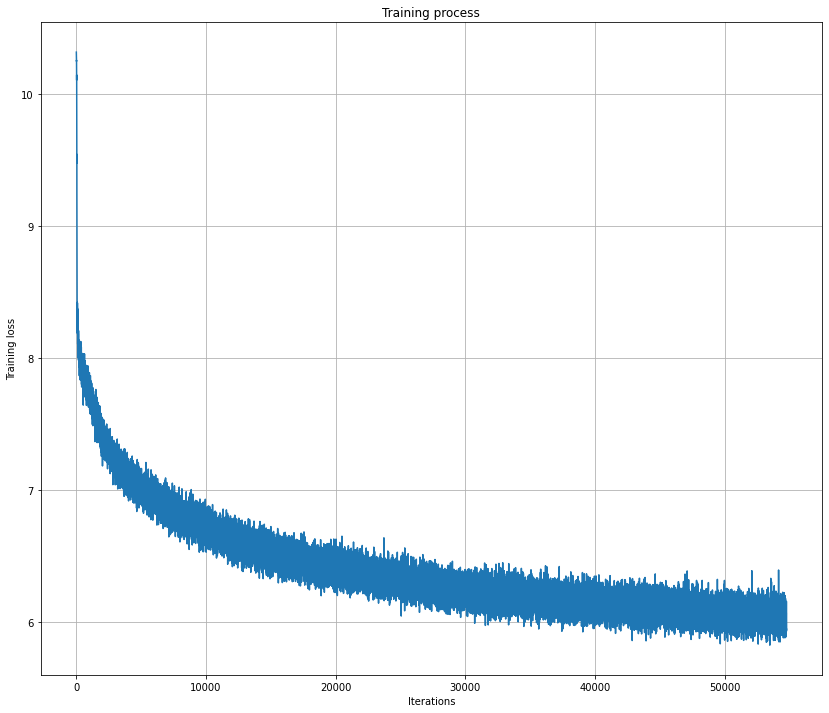

In [21]:
plt.figure(figsize=(14, 12))
plt.plot(trainer.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Training loss');

## Generation

In [22]:
model = Seq2SeqModel()
model.load_state_dict(torch.load('model_best.pt', map_location='cpu'))
model.eval()

Seq2SeqModel(
  (embedding): Embedding(30000, 100, padding_idx=0)
  (embedding_dropout): SpatialDropout(p=0.25, inplace=False)
  (encoder): LSTM(100, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (cat_embedding): Embedding(15, 5)
  (decoder): LSTM(100, 256, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (lm_head): Linear(in_features=517, out_features=30000, bias=True)
)

In [23]:
def generate_beam(question, category, k: int = 3, max_length: int = 100, device: str = 'cpu'):
    question = pack_sequence([torch.tensor(tokenizer.encode(question, bos=True, eos=True)).long()])
    category = torch.tensor([category_mapping[category]]).long()
    
    question = question.to(device)
    category = category.to(device)
    
    beam = {
        1.0: [val_dataset.bos_index]
    }
    beam_next = {}
    
    while True:
        for score, indices in beam.items():
            if len(indices) >= max_length or indices[-1] == val_dataset.eos_index:
                beam_next[score] = indices
                continue
            
            with torch.no_grad():
                y_in = torch.tensor([indices]).long()
                y_in = y_in.to(device)
                logits = model(question, y_in, category)
                probs = F.softmax(logits[0, -1, :], dim=0)
                top_k_indices = probs.argsort()[-k:]
            
            for idx in top_k_indices:
                beam_next[score * probs[idx].item()] = indices + [idx.item()]
                
        beam = {key: value for key, value in sorted(beam_next.items())[-k:]}
        beam_next = {}
        
        if all(len(indices) >= max_length or indices[-1] == val_dataset.eos_index
               for indices in beam.values()):
            break
        
    best_indices = max(beam.items())[1]
    
    return tokenizer.decode(best_indices)

In [24]:
for sample in np.random.choice(val, 10):
    question = sample['question']
    category = sample['category']
    model_response = generate_beam(question, category)
    
    print(f'Category:{category}\nQuestion: "{question}"\nModel response: {" ".join(model_response)}\n')

Category:досуг, развлечения
Question: "челы помогите чем занятся летом в каникулы?"
Model response: <BOS> а что за бред?<EOS>

Category:искусство и культура
Question: "есть ли у оливии кук страничка в социальных сетях? есть ли страничка"
Model response: <BOS> у нас в городе есть.<EOS>

Category:животные, растения
Question: "почему постельные клопы выходят вечером? и укус чем вреден? они мужчин кусают?"
Model response: <BOS> потому что они не умеют<EOS>

Category:семья, дом, дети
Question: "помогите!! ! очень срочно! может у кого так было.. . особенно врачи!"
Model response: <BOS> а у меня нет<EOS>

Category:животные, растения
Question: "на стенках аквариума из оргстекла вверху образовался белый налет (от испарения воды). как его удалить?"
Model response: <BOS> а у нас в городе есть<EOS>

Category:образование
Question: "как побороть лень?"
Model response: <BOS> а зачем тебе это?<EOS>

Category:красота и здоровье
Question: "в каких пропорциях развести яблочный уксус с водой, чтобы сбить 

# What was done

1. Dataset + Model + training loop
2. LSTM + attention seq2seq model, conditioned on question category
3. Gradient accumulation (effective batch size = 1024)
4. Beam search decoding